# Explicabilidad del Modelo (XAI) con SHAP

En este notebook analizamos el comportamiento del modelo de detección de fraude utilizando **SHAP (SHapley Additive exPlanations)**.

El objetivo es entender no solo **qué** predice el modelo, sino **por qué** lo predice, desglosando la decisión en:
1.  **Explicabilidad Global:** ¿Qué variables son las más importantes para el modelo en general?
2.  **Explicabilidad Local:** ¿Por qué se clasificó una transacción específica como fraude?

Este análisis es crucial para cumplir con normativas bancarias y generar confianza en el sistema automático.

Utilizaremos **SHAP (SHapley Additive exPlanations)**, una técnica basada en la teoría de juegos que asigna a cada variable un valor de importancia para cada predicción individual. Esto nos permite responder a:
1.  **Nivel Global:** ¿Qué patrones generales ha aprendido el modelo? (ej. ¿Importa más el monto o la hora?)
2.  **Nivel Local:** ¿Por qué se bloqueó esta transacción específica? (Cumplimiento normativo y gestión de reclamaciones).

In [11]:
import sys
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split

# Ajuste de rutas:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.load_data import load_fraud_csv, load_credit_scoring_data

# Inicializamos JS para ver los gráficos interactivos de SHAP
shap.initjs()

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


In [12]:
ruta_dataset = '../data/credit_card.csv'

if not os.path.exists(ruta_dataset):
    print(f"⚠️ Error: No se encuentra el archivo en {ruta_dataset}")
else:
    df, X, y = load_fraud_csv(ruta_dataset)
    print("Datos cargados.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

amount_train = X_train['Amount']

print(f"Dimensiones de X_test: {X_test.shape}")

Loaded 284,807 transactions from credit_card.csv
Fraud rate: 0.17275%
Total fraud amount: $60,127.97
Datos cargados.
Dimensiones de X_test: (56962, 29)


In [13]:
print("Entrenando XGBoost con Coste (Factor=30)...")

# Cargamos el modelo ganador del fraude crediticio
model_path = '../models/fraud_detection_xgboost_final.pkl'
model = joblib.load(model_path)
print(f"Modelo cargado: {type(model).__name__}")

print("Modelo entrenado y listo para explicar")

Entrenando XGBoost con Coste (Factor=30)...
Modelo cargado: XGBClassifier
Modelo entrenado y listo para explicar


In [14]:
print("Calculando valores SHAP... (esto puede tardar unos segundos)")

# Inicializamos el explicador para árboles (optimizado para XGBoost)
explainer = shap.TreeExplainer(model)

# Calculamos los valores SHAP solo para la muestra
shap_values = explainer(X_test)

print(f"Cálculo completado. Forma de los valores SHAP: {shap_values.shape}")

Calculando valores SHAP... (esto puede tardar unos segundos)
Cálculo completado. Forma de los valores SHAP: (56962, 29)


## Explicabilidad Global del Modelo

A continuación, analizamos el **Summary Plot (Gráfico de Abejas)**. Este gráfico es fundamental porque condensa mucha información:
* **Importancia:** Las variables arriba son las más influyentes.
* **Dirección:** Los puntos rojos representan valores altos de la variable. Si los puntos rojos están a la derecha (SHAP positivo), indican que valores altos de esa variable aumentan la probabilidad de fraude.

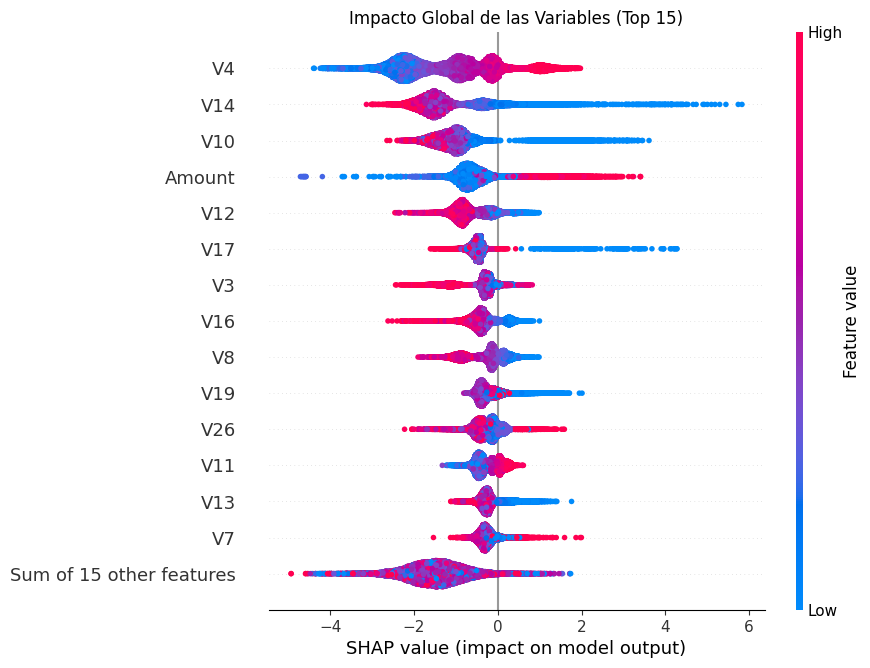

In [ ]:
plt.figure()
plt.title("Impacto Global de las Variables (Top 15)")

shap.plots.beeswarm(shap_values, max_display=15)

output_path = '../results/beeswarm_fraude_global.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [17]:
# Filtramos los índices que son fraude (y=1) y que además están en nuestra muestra pequeña
indices_fraude_real = y_test[y_test == 1].index
indices_en_muestra = [i for i in indices_fraude_real if i in X_test.index]
print(len(indices_en_muestra))

if len(indices_en_muestra) > 0:
    id_transaccion = indices_en_muestra[0] # Cogemos el primero que encontremos
    
    # Buscamos en qué posición (0 a 999) de la matriz SHAP está este ID
    posicion_shap = list(X_test.index).index(id_transaccion)
    
    print(f"Vamos a analizar la transacción ID: {id_transaccion}")
    print(f"Monto de la transacción: {X_test.loc[id_transaccion, 'Amount']}€")
    print(f"Posición en el array SHAP: {posicion_shap}")

98
Vamos a analizar la transacción ID: 77348
Monto de la transacción: 0.01€
Posición en el array SHAP: 840


## Explicabilidad Local (Análisis de Casos)

Para los auditores de riesgo, no basta con la estadística global. Necesitan saber **por qué esta operación específica fue marcada**.

Analizaremos un **Falso Positivo** (Transacción legítima marcada como fraude). Este es el caso más costoso operativamente (molestia al cliente). Usaremos un gráfico de **Waterfall (Cascada)** para desglosar la decisión.

* $E[f(x)]$: Es el "valor base" o la probabilidad promedio de fraude del conjunto de datos.
* Cada barra muestra cómo una variable empuja la probabilidad hacia arriba (rojo/fraude) o hacia abajo (azul/legítimo) desde ese valor base.
* $f(x)$: Es la puntuación final otorgada por el modelo a esta transacción.

<Figure size 640x480 with 0 Axes>

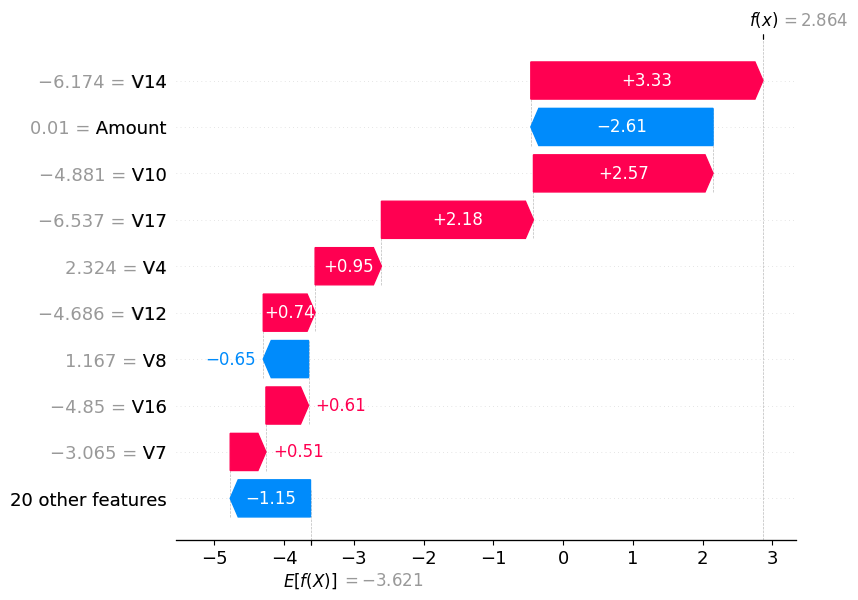

In [18]:
if len(indices_en_muestra) > 0:
    plt.figure()

    output_path = '../results/waterfall_fraude.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    shap.plots.waterfall(shap_values[posicion_shap])

### Caso A: Transacción de Alto Riesgo (Posible Fraude)

En este ejemplo, analizamos una transacción que el modelo ha marcado con una alta probabilidad de ser fraude.

**Análisis:**
Podemos ver las "culpables" principales. Por ejemplo, si `NumberOfTime30-59DaysPastDueNotWorse` aparece en rojo con un valor alto, significa que el historial de impagos recientes del cliente es la razón principal por la que el modelo desconfía de esta operación específica.


--- Buscando Falsos Negativos (Fraudes que se nos escaparon) ---
Analizando Falso Negativo ID: 52584
Importe perdido: 1.0€


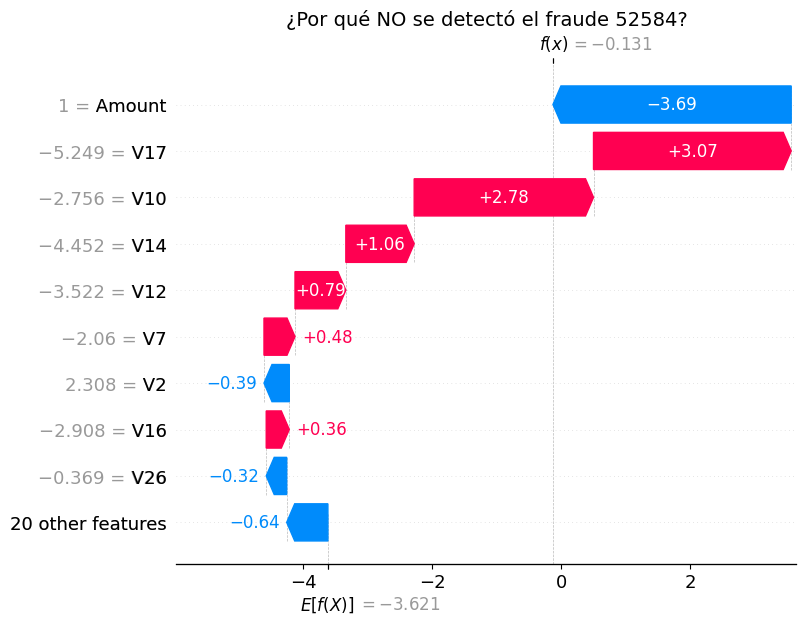

In [19]:
print("\n--- Buscando Falsos Negativos (Fraudes que se nos escaparon) ---")

preds_muestra = model.predict(X_test)

# Buscamos índices donde Realidad=1 (Fraude) pero Predicción=0 (Legítimo)
falsos_negativos = [i for i, y_real, y_pred in zip(X_test.index, y_test.loc[X_test.index], preds_muestra) 
                    if y_real == 1 and y_pred == 0]

if len(falsos_negativos) > 0:
    idx_fn = falsos_negativos[0] 
    pos_fn = list(X_test.index).index(idx_fn)
    
    print(f"Analizando Falso Negativo ID: {idx_fn}")
    print(f"Importe perdido: {X_test.loc[idx_fn, 'Amount']}€")
    
    # Waterfall plot para ver por qué el modelo bajó la puntuación
    plt.figure()
    shap.plots.waterfall(shap_values[pos_fn], show=False)
    plt.title(f"¿Por qué NO se detectó el fraude {idx_fn}?", fontsize=14)
    plt.show()
else:
    print("¡Increíble! El modelo no tuvo falsos negativos en esta muestra.")

# ==========================================
# PARTE 2: EXPLICABILIDAD - CREDIT SCORING (SHAP)
# ==========================================

En esta sección utilizamos la técnica **SHAP (SHapley Additive exPlanations)** para abrir la "caja negra" de nuestro modelo de riesgo de crédito.
El objetivo es responder a dos preguntas clave para el negocio y el regulador:
1.  **Explicabilidad Global:** ¿Qué variables (Ingresos, Deuda, Edad...) tienen más peso general en la decisión de conceder un crédito?
2.  **Explicabilidad Local:** Ante un cliente concreto rechazado, ¿cuáles fueron las razones exactas? (Esencial para dar feedback al cliente).

In [20]:
df_cs, X_cs, y_cs = load_credit_scoring_data('../data/cs-training.csv')
X_train, X_test, y_train, y_test = train_test_split(X_cs, y_cs, test_size=0.2, stratify=y_cs, random_state=42)

model_path = '../models/credit_scoring_final_model.pkl'
model = joblib.load(model_path)
print(f"Modelo cargado: {type(model).__name__}")

explainer = shap.TreeExplainer(model)

Credit Scoring Data Loaded: 150,000 records
Default Rate: 6.68%
Total Estimated Exposure: $5,778,889,522
Modelo cargado: XGBClassifier


In [21]:
print("Calculando explicaciones...")
shap_values_obj = explainer(X_test)

Calculando explicaciones...



--- IMPACTO GLOBAL DE VARIABLES ---


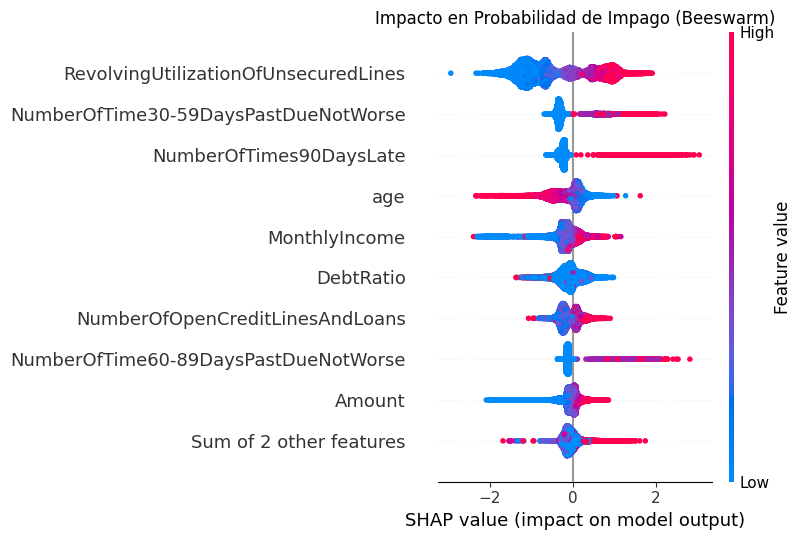

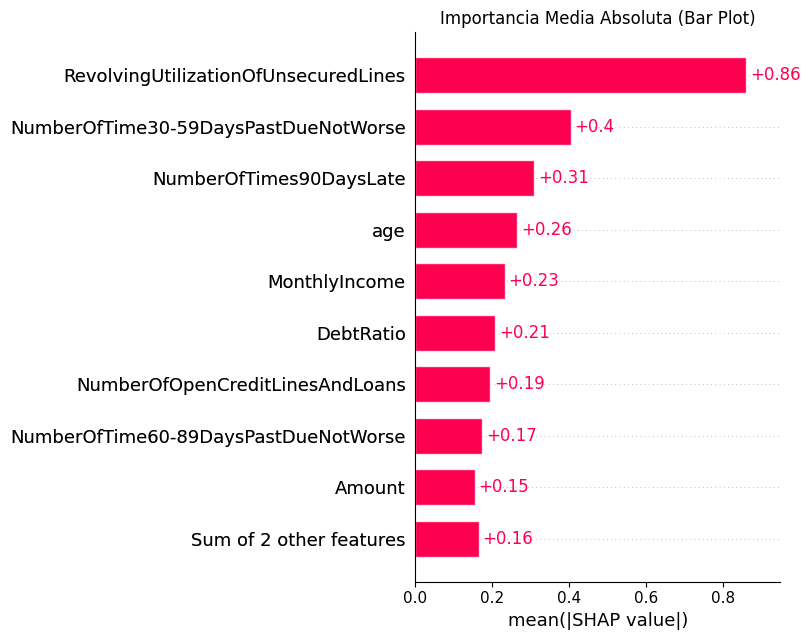

In [22]:
print("\n--- IMPACTO GLOBAL DE VARIABLES ---")

plt.figure(figsize=(10, 6))
plt.title("Impacto en Probabilidad de Impago (Beeswarm)")
# beeswarm maneja automáticamente el objeto Explanation
shap.plots.beeswarm(shap_values_obj, show=False)
plt.tight_layout()

output_path = '../results/beeswarm_creditscoring_global.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()

plt.figure(figsize=(10, 6))
plt.title("Importancia Media Absoluta (Bar Plot)")
shap.plots.bar(shap_values_obj, show=False)
plt.tight_layout()
plt.show()


--- ANÁLISIS INDIVIDUAL (WATERFALL) ---
Explicando decisión para cliente (Índice muestra: 7)
Probabilidad Modelo: 88.85%
Umbral Corte:        68.30%


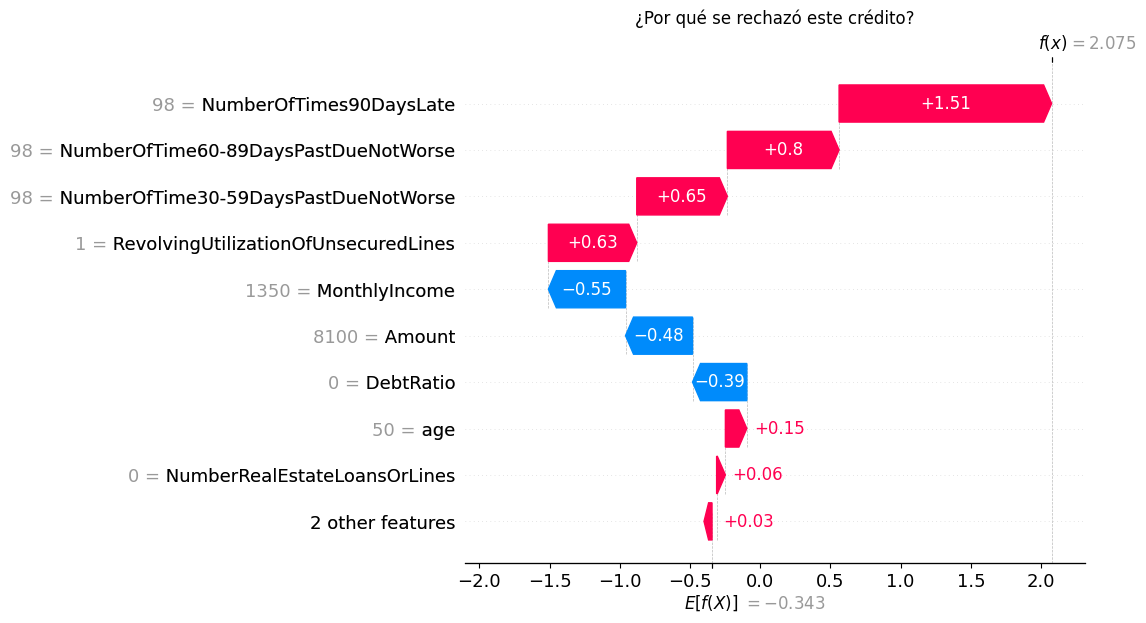

In [23]:
print("\n--- ANÁLISIS INDIVIDUAL (WATERFALL) ---")

# Definir Umbral Operativo (Calculado en análisis de sensibilidad)
OPERATING_THRESHOLD = 0.683 

# Buscar un cliente rechazado en la muestra
probs_sample = model.predict_proba(X_test)[:, 1]
rejected_indices_local = np.where(probs_sample > OPERATING_THRESHOLD)[0]

if len(rejected_indices_local) > 0:
    # Elegir el primero de la muestra
    idx_in_sample = rejected_indices_local[0]
    
    # Extraer el objeto Explanation de ESE cliente
    # shap_values_obj ya tiene los nombres de columnas y datos base integrados
    single_explanation = shap_values_obj[idx_in_sample]
    
    print(f"Explicando decisión para cliente (Índice muestra: {idx_in_sample})")
    print(f"Probabilidad Modelo: {probs_sample[idx_in_sample]:.2%}")
    print(f"Umbral Corte:        {OPERATING_THRESHOLD:.2%}")
    
    plt.figure()
    # El gráfico waterfall ahora recibe directamente el objeto explanation individual
    shap.plots.waterfall(single_explanation, show=False, max_display=10)
    plt.title("¿Por qué se rechazó este crédito?")

    output_path = '../results/waterfall_creditscoring.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()
    
else:
    print("No hay clientes rechazados en esta pequeña muestra para graficar.")